# 🛍️ Project Notebook
Section UU
- Vanessa DiPietrantonio 40189938
- Michaël Gugliandolo 40213419
- Jessey Thach 40210440
- Mahanaim Rubin Yo 40178119


## 📥 Part 1: Data Preprocessing
Steps:
- Load `ecommerce_user_data.csv` and `product_details.csv`
- Merge data if necessary
- Create user-item matrix
- Fill missing ratings with 0
- Group user behavior by category

In [32]:
# Load data
import pandas as pd

user_data = pd.read_csv('data/ecommerce_user_data.csv')
product_data = pd.read_csv('data/product_details.csv')

print(user_data.head())
print(product_data.head())

  UserID ProductID  Rating   Timestamp  Category
0   U000     P0009       5  2024-09-08     Books
1   U000     P0020       1  2024-09-02      Home
2   U000     P0012       4  2024-10-18     Books
3   U000     P0013       1  2024-09-18  Clothing
4   U000     P0070       4  2024-09-16      Toys
  ProductID      ProductName     Category
0     P0000      Toys Item 0     Clothing
1     P0001  Clothing Item 1  Electronics
2     P0002     Books Item 2  Electronics
3     P0003  Clothing Item 3  Electronics
4     P0004  Clothing Item 4  Electronics


In [33]:
# Merge datasets on ProductID to get complete info
data = pd.merge(user_data, product_data, on='ProductID', how='left')
print(data.head())

  UserID ProductID  Rating   Timestamp Category_x       ProductName Category_y
0   U000     P0009       5  2024-09-08      Books   Clothing Item 9      Books
1   U000     P0020       1  2024-09-02       Home  Clothing Item 20       Home
2   U000     P0012       4  2024-10-18      Books    Beauty Item 12      Books
3   U000     P0013       1  2024-09-18   Clothing  Clothing Item 13   Clothing
4   U000     P0070       4  2024-09-16       Toys    Beauty Item 70       Toys


In [34]:
# Create user-item matrix
user_item_matrix = user_data.pivot_table(index='UserID', columns='ProductID', values='Rating')
user_item_matrix_filled = user_item_matrix.fillna(0)
user_item_matrix_filled.head()

ProductID,P0000,P0001,P0002,P0003,P0004,P0005,P0006,P0007,P0008,P0009,...,P0090,P0091,P0092,P0093,P0094,P0095,P0096,P0097,P0098,P0099
UserID,,,,,,,,,,,,,,,,,,,,,
U000,0.0,0.0,0.0,3.0,0.0,5.0,0.0,3.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U001,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
U002,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
U004,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0


In [35]:
# Aggregate user behavior by category
user_category_agg = user_data.groupby(['UserID', 'Category']).agg({'Rating': ['count', 'mean']}).reset_index()
user_category_agg.columns = ['UserID', 'Category', 'TotalInteractions', 'AverageRating']
user_category_agg.head()

,UserID,Category,TotalInteractions,AverageRating
0,U000,Books,6,3.666667
1,U000,Clothing,3,1.666667
2,U000,Electronics,3,3.666667
3,U000,Home,2,1.000000
4,U000,Toys,6,3.500000


## 🤝 Part 2: User-Based Collaborative Filtering
Steps:
- Use cosine similarity to compare users
- Recommend top-N products based on similar users
- Evaluate with Precision@K and Coverage

In [36]:
# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(user_item_matrix_filled)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix_filled.index, columns=user_item_matrix_filled.index)
similarity_df.head()

UserID,U000,U001,U002,U003,U004,U005,U006,U007,U008,U009,...,U040,U041,U042,U043,U044,U045,U046,U047,U048,U049
UserID,,,,,,,,,,,,,,,,,,,,,
U000,1.000000,0.063071,0.195522,0.023466,0.065412,0.161251,0.160096,0.092083,0.238263,0.274844,...,0.241693,0.129483,0.156790,0.132200,0.161478,0.100346,0.126917,0.150727,0.000000,0.104294
U001,0.063071,1.000000,0.190861,0.000000,0.111332,0.009540,0.000000,0.172286,0.167460,0.017593,...,0.121540,0.024075,0.097953,0.007821,0.000000,0.000000,0.193670,0.247805,0.000000,0.000000
U002,0.195522,0.190861,1.000000,0.065094,0.111662,0.050830,0.027756,0.055877,0.000000,0.181229,...,0.144756,0.000000,0.217465,0.000000,0.055992,0.034794,0.194243,0.110030,0.177165,0.000000
U003,0.023466,0.000000,0.065094,1.000000,0.035737,0.104116,0.026650,0.000000,0.025384,0.288009,...,0.243836,0.000000,0.000000,0.074688,0.197121,0.000000,0.054396,0.126773,0.374228,0.250000
U004,0.065412,0.111332,0.111662,0.035737,1.000000,0.159064,0.057144,0.026294,0.195942,0.247023,...,0.062741,0.116202,0.078797,0.048044,0.103747,0.133716,0.124969,0.217464,0.255318,0.172729


In [40]:
# Create recommendation function
# Find most similar user, recommend products they rated highly that target user hasn’t rated

# Function to get top-N similar users for a given user
def get_top_similar_users(user_id, similarity_matrix, n=3):
    # Exclude the target user and sort by similarity
    similar_scores = similarity_matrix.loc[user_id].drop(user_id)
    top_users = similar_scores.nlargest(n).index.tolist()
    return top_users

# Function to generate product recommendations for a given user
def recommend_products(user_id, matrix, similarity_matrix, n_similar=3, top_n=5):
    top_users = get_top_similar_users(user_id, similarity_matrix, n=n_similar)
    similar_ratings = matrix.loc[top_users]
    user_rated = matrix.loc[user_id]

    scores = {}
    for product in matrix.columns:
        if user_rated[product] == 0:
            scores[product] = similar_ratings[product].mean()

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    rec_df = pd.DataFrame(sorted_scores[:top_n], columns=['ProductID', 'AvgRating'])
    recommend_products = rec_df.merge(product_data, on='ProductID', how='left')
    return recommend_products

example_user = user_item_matrix.index[0]
print(f"Top recommendations for {example_user}:")
print(recommend_products(example_user, user_item_matrix_filled, similarity_df))

Top recommendations for U000:
  ProductID  AvgRating       ProductName     Category
0     P0051   3.000000      Home Item 51     Clothing
1     P0052   2.666667      Home Item 52        Books
2     P0088   2.333333  Clothing Item 88        Books
3     P0060   2.000000      Toys Item 60         Home
4     P0029   1.666667     Books Item 29  Electronics


In [44]:
# Implement evaluation metrics like Precision@K and Coverage
# Example: compare recommended vs actual rated items
import random
import numpy as np
from sklearn.metrics import average_precision_score

# Train/test split
def train_test_split(matrix, test_ratio=0.2):
    train = matrix.copy()
    test = pd.DataFrame(0, index=matrix.index, columns=matrix.columns)

    for user in matrix.index:
        rated_items = matrix.loc[user][matrix.loc[user] > 0].index.tolist()
        n_test = int(len(rated_items) * test_ratio)
        test_items = random.sample(rated_items, n_test) if n_test > 0 else []
        train.loc[user, test_items] = 0
        test.loc[user, test_items] = matrix.loc[user, test_items]

    return train, test

# Split the data
train_matrix, test_matrix = train_test_split(user_item_matrix_filled)

# Recalculate similarity on training data
train_similarity = pd.DataFrame(cosine_similarity(train_matrix), index=train_matrix.index, columns=train_matrix.index)

# Evaluation metrics
def precision_at_k(user, recs, test_data, k=5, threshold=3):
    relevant = test_data.loc[user][test_data.loc[user] >= threshold].index.tolist()
    predicted = recs['ProductID'].tolist() if not recs.empty else []
    hits = len(set(relevant) & set(predicted))
    return hits / k

def recall_at_k(user, recs, test_data, k=5, threshold=3):
    relevant = test_data.loc[user][test_data.loc[user] >= threshold].index.tolist()
    if not relevant:
        return 0
    predicted = recs['ProductID'].tolist() if not recs.empty else []
    hits = len(set(relevant) & set(predicted))
    return hits / len(relevant)

# Evaluate on all users
precisions, recalls, maps = [], [], []
recommendation_dict = {}

precisions, recalls, maps = [], [], []
recommendation_dict = {}

for user in train_matrix.index:
    recs = recommend_products(user, train_matrix, train_similarity)
    recommendation_dict[user] = recs['ProductID'].tolist() if not recs.empty else []

    # Precision & Recall
    p = precision_at_k(user, recs, test_matrix)
    r = recall_at_k(user, recs, test_matrix)
    precisions.append(p)
    recalls.append(r)

    # MAP
    relevant_items = test_matrix.loc[user]
    y_true = (relevant_items >= 3).astype(int)
    y_scores = pd.Series(0, index=train_matrix.columns)

    if not recs.empty:
        for product in recs['ProductID']:
            if product in y_scores.index:
                y_scores[product] = 1
        try:
            maps.append(average_precision_score(y_true, y_scores))
        except:
            maps.append(0)
    else:
        maps.append(0)

print(f"\n--- Evaluation Summary ---")
print(f"Precision@5: {np.mean(precisions):.4f}")
print(f"Recall@5   : {np.mean(recalls):.4f}")
print(f"MAP        : {np.mean(maps):.4f}")

# Coverage: % of unique items recommended to all users
all_recommended_items = set(p for recs in recommendation_dict.values() for p in recs)
coverage = len(all_recommended_items) / len(train_matrix.columns)
print(f"Coverage   : {coverage:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive c


--- Evaluation Summary ---
Precision@5: 0.0320
Recall@5   : 0.1067
MAP        : 0.0347
Coverage   : 0.8000


## 🔍 Part 3: Association Rule Mining (Apriori)
Steps:
- Convert user-product interactions to transaction format
- Apply Apriori algorithm to find frequent itemsets
- Generate association rules (support, confidence, lift)

In [45]:
# Convert to transaction format
from mlxtend.preprocessing import TransactionEncoder
transactions = user_data.groupby('UserID')['ProductID'].apply(list).tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)
print(df_trans.head())

   P0000  P0001  P0002  P0003  P0004  P0005  P0006  P0007  P0008  P0009  ...  \
0  False  False  False   True  False   True  False   True  False   True  ...   
1  False  False   True  False  False  False  False  False  False  False  ...   
2  False  False  False  False  False   True  False  False  False  False  ...   
3  False  False  False  False  False  False  False  False  False  False  ...   
4  False   True  False  False  False  False   True  False  False  False  ...   

   P0090  P0091  P0092  P0093  P0094  P0095  P0096  P0097  P0098  P0099  
0  False  False  False  False  False  False  False  False  False  False  
1  False   True  False  False  False   True  False  False  False  False  
2  False  False  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False   True  False  False  
4  False  False   True  False  False  False  False  False   True   True  

[5 rows x 100 columns]


In [46]:
# Apply Apriori and generate rules
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

  antecedents consequents  support  confidence      lift
0     (P0000)     (P0008)     0.06    0.500000  2.777778
1     (P0000)     (P0023)     0.06    0.500000  3.125000
2     (P0000)     (P0030)     0.06    0.500000  2.272727
3     (P0000)     (P0071)     0.06    0.500000  2.777778
4     (P0091)     (P0001)     0.08    0.571429  3.174603


## 📊 Part 4: Visualization
Steps:
- Plot user similarity heatmap
- Plot top frequent itemsets
- Visualize top recommendations

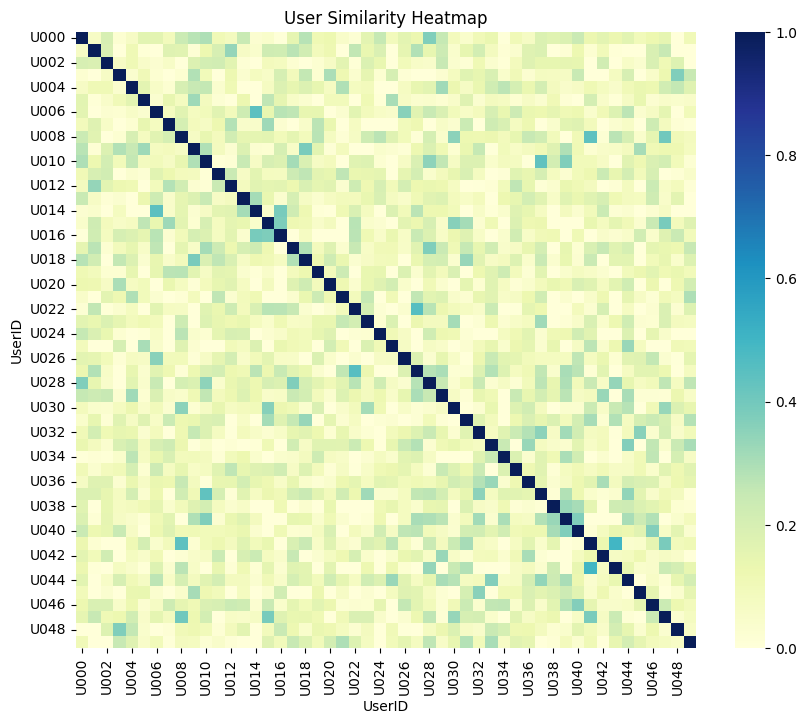

In [47]:
# Heatmap of user similarity
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='YlGnBu')
plt.title('User Similarity Heatmap')
plt.show()

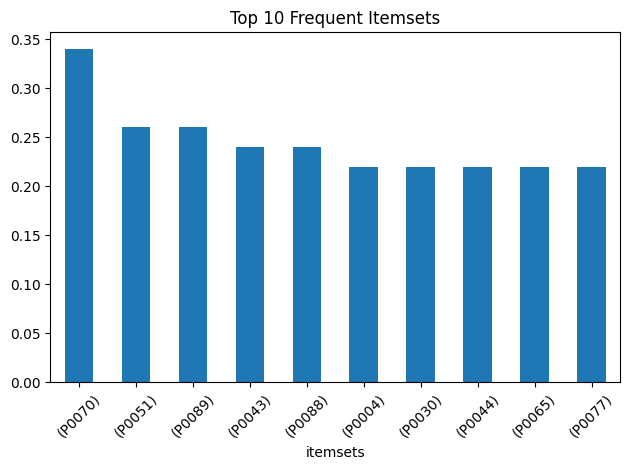

In [48]:
# Frequent itemsets bar chart
frequent_itemsets.nlargest(10, 'support').plot(kind='bar', x='itemsets', y='support', legend=False)
plt.title('Top 10 Frequent Itemsets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

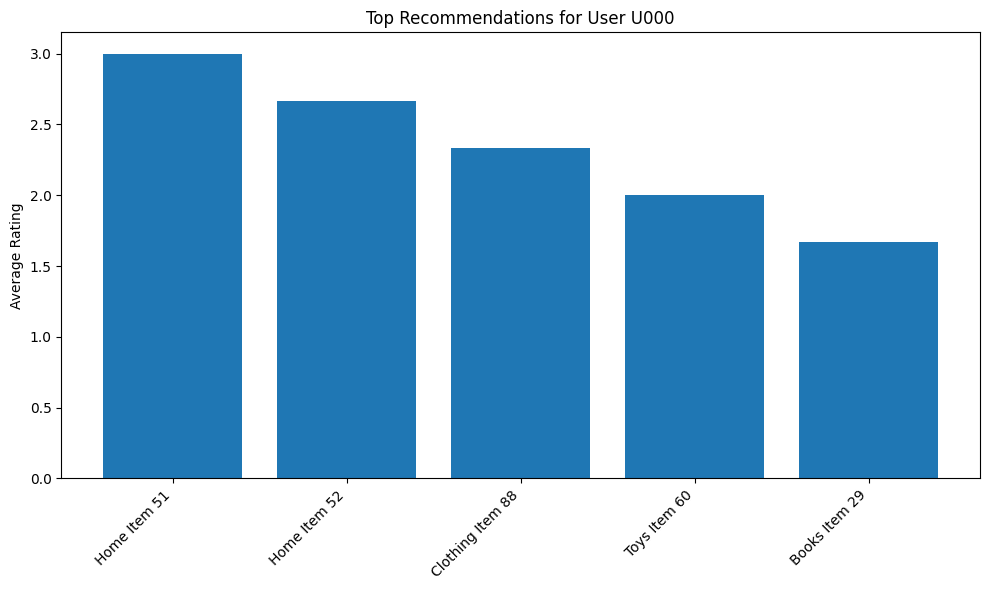

In [49]:
# Visualize top recommendations for an example user.
# Generate recommendations for an example user.
example_user = user_item_matrix_filled.index[0]
top_recs = recommend_products(example_user, user_item_matrix_filled, similarity_df)

plt.figure(figsize=(10, 6))
plt.bar(top_recs['ProductName'], top_recs['AvgRating'])
plt.title(f"Top Recommendations for User {example_user}")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Rating")
plt.tight_layout()
plt.savefig("top_recommendations.png")
plt.show()